In [1]:
# Load the libraries
import wrmsse_utility as w
from datetime import date, timedelta
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm
import lightgbm as lgb
import random
import warnings
warnings.filterwarnings('ignore')

# Load pickle files
def save_obj(obj, name):
    with open(  name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_weights2(name):
    with open('../input/weights2/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def load_avoid_spike(name):
    with open('../input/avoid-spike/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def load_from_scratch(name):
    with open('../input/from-scratch/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def load_clusters(name):
    with open('../input/clusters/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
# Load the data
train_df = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_evaluation.csv")
calendar = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv")
price = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv")
submission = pd.read_csv("../input/m5-forecasting-accuracy/sample_submission.csv")

# Define global variables
category_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
no_id_id_columns = ['item_id', 'store_id', 'cat_id', 'dept_id', 'state_id']
id_cols = ["id"] + category_cols
id_df = train_df[id_cols]  # id_df not encoded
print("running")

# Label Encoding of categorical variables
mapper = {}
for col in category_cols:
    le = LabelEncoder()
    mapper[col] = dict(zip(le.fit_transform(train_df[col]), train_df[col]))
    train_df[col] = le.fit_transform(train_df[col])

# Define index related global variables
multi_indexes = train_df.set_index(category_cols).index  # multi_indexes are encoded
INDEX_ITEM = multi_indexes.get_level_values("item_id")
INDEX_DEPT = multi_indexes.get_level_values("dept_id")
INDEX_STORE = multi_indexes.get_level_values("store_id")


# Create ordered_ids_and_weights -- Weights are pre-calculated
agg_level_to_denominator = load_weights2("agg_to_denominator2")
agg_level_to_weight = load_weights2("agg_to_weight2")

# Calculate constants of evaluation metric
final_multiplier = (agg_level_to_weight[11]) / agg_level_to_denominator[11]
final_multiplier = final_multiplier.reset_index()
final_multiplier["id"] = final_multiplier["item_id"] + "_" + final_multiplier["store_id"] + "_evaluation"
final_multiplier.drop(["item_id", "store_id"], axis=1, inplace=True)
del agg_level_to_weight, agg_level_to_denominator
gc.collect()

# Order the constants
ordered_ids_and_weights = pd.merge(id_df, final_multiplier, on=["id"], how="left")
ordered_ids_and_weights = ordered_ids_and_weights[[0]]
ordered_ids_and_weights.index = multi_indexes
ordered_ids_and_weights = ordered_ids_and_weights.reset_index()
ordered_ids_and_weights = ordered_ids_and_weights.rename({0: "weights"}, axis=1)


# Set train data column names
train_df.set_index(keys=id_cols, inplace=True)
start_date = date(2011, 1, 29)
train_df.columns = pd.date_range(start_date, freq="D", periods=1941)
train_df.reset_index(inplace=True)


# Calendar pre-processing
calendar["date"] = pd.to_datetime(calendar.date)

# Preprocess price -- represent dates as columns
price_df = pd.merge(price, id_df, how="left", on=["item_id", "store_id"])

tmp = calendar[["wm_yr_wk", "date"]]
tmp = tmp.groupby("wm_yr_wk").agg(list).reset_index()
price_df = pd.merge(price_df, tmp, how="left", on="wm_yr_wk")
price_df = price_df.explode("date")
price_df.drop(["wm_yr_wk"], axis=1, inplace=True)

price_df = price_df.set_index(id_cols + ["date"])
price_df = price_df[["sell_price"]].unstack()
price_df.columns = price_df.columns.droplevel()
price_df.reset_index(inplace=True)


# Preprocess Calendar and SNAP
tmp = calendar[["date", "event_name_1"]]


tmp2 = tmp.dropna(axis=0)
calendar_df = pd.DataFrame(columns=pd.date_range(start_date, freq="D", periods=1913 + 56),
                           index=tmp2.event_name_1.unique())
tmp3 = tmp2.groupby("event_name_1").agg(list).reset_index()
a = zip(tmp3["event_name_1"], tmp3["date"])

for row, col in a: calendar_df.loc[row, col] = 1

# Merge SNAP vairables into 1 column
snap_ca = pd.DataFrame(index=["CA"], columns=pd.date_range(start_date, freq="D", periods=1913 + 56))
snap_tx = pd.DataFrame(index=["TX"], columns=pd.date_range(start_date, freq="D", periods=1913 + 56))
snap_wa = pd.DataFrame(index=["WI"], columns=pd.date_range(start_date, freq="D", periods=1913 + 56))

snap_ca.loc["CA", :] = calendar["snap_CA"].values
snap_tx.loc["TX", :] = calendar["snap_TX"].values
snap_wa.loc["WI", :] = calendar["snap_WI"].values
snap_df = pd.concat([snap_ca, snap_tx, snap_wa])

calendar_df = calendar_df.fillna(0)

#Remove Repeating records in Calendar and create seperate series for NBA and Ramadan
calendar_df = calendar_df.loc[calendar_df.index!= "LentWeek2",]
calendar_df.iloc[-1,:] = calendar_df.iloc[6,:].values + calendar_df.iloc[-1,:].values # Easter Fix
calendar_df.iloc[-6,:] = calendar_df.iloc[-3,:].values + calendar_df.iloc[-6,:].values # Christmas Fix

NBA = (calendar_df.iloc[11,:].values + calendar_df.iloc[12,:].values).cumsum() %2
NBA = pd.Series(NBA, index=calendar_df.columns)
RAMADAN = (calendar_df.iloc[15,:].values + calendar_df.iloc[16,:].values).cumsum() %2
RAMADAN = pd.Series(RAMADAN, index=calendar_df.columns)

calendar_df = calendar_df.loc[~calendar_df.index.isin(["OrthodoxEaster","OrthodoxChristmas","NBAFinalsStart",\
                                                       "NBAFinalsEnd","Ramadan starts","Eid al-Fitr"]),]

# Store mappings of the event and state encodings
event_mapper = dict(zip(list(range(1,24)),list(calendar_df.index)))
calendar_df = ((np.arange(1,24) * calendar_df.T).T).sum()

mapper_back_state = {v: k for k, v in mapper["state_id"].items()}
snap_df.index = snap_df.index.map(mapper_back_state)


del snap_ca, snap_tx, snap_wa, tmp, tmp2, tmp3, calendar, price, mapper_back_state

print("Dataframes are ready...")


print("Converting the leading zeros into NaNs ...")
# Turn leading zeros into NAs
for i in tqdm(range(len(train_df)),leave=False):
    series = train_df.iloc[i, 6:].values
    to_index = (np.argmax(series != 0))
    train_df.iloc[i, 6:to_index] = np.NaN


running
Dataframes are ready...


In [4]:
# Select only the part of the data that will be used in training and feature engineering
def sample_from_train(train_df, start, end):
    return train_df[ id_cols + list(pd.date_range(start, end))]

# Select the data between minus days before the date_from and date_from
def get_timespan(df, date_from, minus, periods, freq="D"):
    return df[pd.date_range(date_from - timedelta(days=minus), periods=periods, freq=freq)]


In [5]:
# Create sales related features
def fe(df, date_from, get_label=True, name_prefix=None):
    X = dict()

    for i in [3, 7, 30, 180]:
        tmp = get_timespan(df, date_from, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values

    for i in [3, 7, 15, 30]:
        tmp = get_timespan(df, date_from + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values

    for i in [3, 7, 14, 30, 180]:
        tmp = get_timespan(df, date_from, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values
        X['Number_of_days_to_max_sales_in_last_%s' % i] = (pd.to_datetime(date_from) - pd.to_datetime(
            get_timespan(df, date_from, i, i).idxmax(axis=1).values)).days.values
        X['Number_of_days_to_min_sales_in_last_%s' % i] = (pd.to_datetime(date_from) - pd.to_datetime(
            get_timespan(df, date_from, i, i).idxmin(axis=1).values)).days.values


    for i in range(1, 8):
        X["lag_%s" % i] = get_timespan(df, date_from, i, 1).values.ravel()

    for i in range(7):
        X["mean_4_dow_%s" % i] = get_timespan(df, date_from, 4 * 7 - i, 4, freq="7D").mean(axis=1).values
        X["mean_8_dow_%s" %i] = get_timespan(df, date_from, 8 * 7 - i, 8, freq="7D").mean(axis=1).values
        X["mean_13_dow_%s" % i] = get_timespan(df, date_from, 13 * 7 - i, 13, freq="7D").mean(axis=1).values
        X["mean_26_dow_%s" % i] = get_timespan(df, date_from, 26 * 7 - i, 26, freq="7D").mean(axis=1).values
        X["mean_52_dow_%s" % i] = get_timespan(df, date_from, 52 * 7 - i, 52, freq="7D").mean(axis=1).values

    X = pd.DataFrame(X)

    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
        return X
    
    # LABELS ARE SALES VALUES OF NEXT 28 DAYS
    if get_label:
        y = df[pd.date_range(date_from, periods=28)].values
        return X, y
    else:
        return X
    

In [6]:

# Create event related features
def calendar_fe(calendar_df, date_from, number_of_series=30490, add_bulk=False):
    X={}

    for i in [7, 14, 28]:
        tmp = get_timespan(calendar_df, date_from, i, i)
        if ((tmp > 0) * np.arange(i)).max() == 0:
            X["days_after_last_event_in_last_%s_days" %i] = np.repeat(np.NaN,number_of_series)
        else:
            X["days_after_last_event_in_last_%s_days" %i] = np.repeat(i - ((tmp > 0) * np.arange(i)).max(), number_of_series)


    for i in [7, 14, 28]:
        tmp = get_timespan(calendar_df, date_from + timedelta(days=i), i, i)
        
        if ((tmp > 0 ) * np.arange(i, 0, -1)).max() ==0:
            X["days_to_NEXT_event_in_%s"%i] = np.repeat(np.NaN,number_of_series)
        else:
            X["days_to_NEXT_event_in_%s"%i] = np.repeat(i - ((tmp > 0 ) * np.arange(i, 0, -1)).max(), number_of_series)
    
    X = pd.DataFrame(X)
    
    nba_tmp = get_timespan(NBA, date_from + timedelta(days=28), 28, 28)
    nba_tmp = np.array([nba_tmp]*30490)
    nba_tmp = pd.DataFrame(nba_tmp, columns=["NBA_AT_NEXT_%s_CATEGORICAL"%i for i in range(1,29)])
    
    ramadan_tmp = get_timespan(RAMADAN, date_from + timedelta(days=28), 28, 28)
    ramadan_tmp = np.array([ramadan_tmp]*30490)
    ramadan_tmp = pd.DataFrame(ramadan_tmp, columns=["RAMADAN_AT_NEXT_%s_CATEGORICAL"%i for i in range(1,29)])
    
    cal_tmp = get_timespan(calendar_df, date_from + timedelta(days=28), 28, 28)
    cal_tmp = np.array([cal_tmp]*30490)
    cal_tmp = pd.DataFrame(cal_tmp, columns=["EVENT_AT_NEXT_%s_CATEGORICAL"%i for i in range(1,29)])
    
    X = pd.concat([X,nba_tmp,ramadan_tmp,cal_tmp],axis=1)
    return X

In [7]:
# Create price related features
def price_fe(price_df, date_from):
    X={}
    for i in [28]:
        tmp = get_timespan(price_df, date_from + timedelta(days=i), i, i)
        X["max_price_NEXT_%s_days" %i] = tmp.max(axis=1).values
        X["min_price_NEXT_%s_days" % i] = tmp.min(axis=1).values
        X["days_to_firt_price_drop_in_NEXT_%s_days_CATEGORICAL"] = (((tmp.diff(axis=1)<0)*np.arange(i)).max(axis=1)).replace(0,np.NaN)
        X["days_to_firt_price_increase_in_NEXT_%s_days_CATEGORICAL"] = (((tmp.diff(axis=1)>0)*np.arange(i)).max(axis=1)).replace(0,np.NaN)


    for i in [7,28,180]:
        tmp = get_timespan(price_df, date_from, i, i)
        X["days_after_last_price_drop_%s_days"%i] = (i - ((tmp.diff(axis=1)<0)*np.arange(i)).max(axis=1)).replace(i,np.NaN)
        X["days_after_last_price_increse_%s_days"%i] = (i - ((tmp.diff(axis=1)>0)*np.arange(i)).max(axis=1)).replace(i,np.NaN)
        
        X["max_price_last_%s_days" % i] = tmp.max(axis=1).values
        X["min_price_last_%s_days" % i] = tmp.min(axis=1).values
        X["percent_price_change_last_%s_days" % i] = (X["max_price_last_%s_days" % i] - X[
            "min_price_last_%s_days" % i]) / X["min_price_last_%s_days" % i]
        X["price_NA_last_%s_days" % i] = tmp.isna().sum(axis=1).values

    X = pd.DataFrame(X)
    return X


In [9]:
# Create Train dataset
def create_train_and_val_as_list_of_df(train_df, item_df, store_dept_df, calendar_df, price_df, multi_indexes, val_from, number_of_weeks):
    X_l = []
    y_l = []
    weights = ordered_ids_and_weights.copy()

    for i in tqdm(range(number_of_weeks), leave=False):
        dt_from = val_from + timedelta(days=- i*7)
        
        X, y = fe(train_df, dt_from, get_label=True)
        X_item = fe(item_df, dt_from, get_label=False, name_prefix="Item")
        X_item = X_item.reindex(INDEX_ITEM).reset_index(drop=True)
        X_store_dept = fe(store_dept_df, dt_from, get_label=False, name_prefix="Store_Dept")
        X_store_dept.index = original_store_dept_index
        X_store_dept = X_store_dept.reindex(pd.MultiIndex.from_arrays([INDEX_STORE,INDEX_DEPT])).reset_index(drop=True)
        
        X_calendar = calendar_fe(calendar_df, dt_from)
        X_price = price_fe(price_df, dt_from)

        weights["weights"] *= (0.998**i)
        X_l.append(w.reduce_mem_usage(pd.concat([X, X_item, X_store_dept, X_calendar, X_price, weights], axis=1)))
        y_l.append(y)

    return X_l, y_l

# Create same features this time to describe the status series just before the test start date
def create_test_as_df(train_df, item_df, store_dept_df, calendar_df, price_df, multi_indexes, test_from):
    X_test = fe(train_df, test_from, get_label=False)
    X_item = fe(item_df, test_from, get_label=False, name_prefix="Item")
    X_item = X_item.reindex(INDEX_ITEM).reset_index(drop=True)
    X_store_dept = fe(store_dept_df, test_from, get_label=False, name_prefix="Store_Dept")
    X_store_dept.index = original_store_dept_index
    X_store_dept = X_store_dept.reindex(pd.MultiIndex.from_arrays([INDEX_STORE,INDEX_DEPT])).reset_index(drop=True)
    
    X_calendar = calendar_fe(calendar_df, test_from)
    X_price = price_fe(price_df, test_from)

    return pd.concat([X_test, X_item, X_store_dept, X_calendar, X_price, ordered_ids_and_weights], axis=1)



# define cost function -- From Ragnar's 
def custom_asymmetric_train(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.10)
    hess = np.where(residual < 0, 2, 2 * 1.10)
    return grad, hess

In [10]:
# Define important dates
train_start = date(2013,1,1)
train_end = date(2016, 4, 24)
validation_start = date(2016, 4, 25)
validation_end = date(2016, 5, 22)
test_start =  date(2016, 5, 23)
test_end =  date(2016, 6, 19)

number_of_weeks = 20

#### IF wanted to try CV on last years periods --> validation weeks will be popped with [48, 100] ####
###  pd.date_range includes both sides when start and end given ###
###  only includes start and adds periods when used with periods and freq ###

# Select fresh examples
train_df = sample_from_train(train_df, train_start, validation_end)
price_df = sample_from_train(price_df, train_start, test_end)
item_df = train_df.groupby(["item_id"]).sum().iloc[:,4:]
store_dept_df = train_df.groupby(["store_id","dept_id"]).sum().iloc[:,3:]
original_store_dept_index = store_dept_df.index


# Create train, labels  and test
X_l, y_l = create_train_and_val_as_list_of_df(train_df, item_df, store_dept_df, calendar_df, price_df,\
                                              multi_indexes, validation_start, number_of_weeks)


test_X = create_test_as_df(train_df, item_df, store_dept_df, calendar_df, price_df, multi_indexes, test_start)

  5%|▌         | 1/20 [00:11<03:29, 11.02s/it]

Mem. usage decreased to 24.05 Mb (78.8% reduction)


 10%|█         | 2/20 [00:21<03:14, 10.81s/it]

Mem. usage decreased to 24.05 Mb (78.8% reduction)


 15%|█▌        | 3/20 [00:31<03:01, 10.67s/it]

Mem. usage decreased to 24.16 Mb (78.7% reduction)


 20%|██        | 4/20 [00:41<02:48, 10.55s/it]

Mem. usage decreased to 24.05 Mb (78.8% reduction)


 25%|██▌       | 5/20 [00:52<02:37, 10.47s/it]

Mem. usage decreased to 24.05 Mb (78.8% reduction)


 30%|███       | 6/20 [01:02<02:27, 10.50s/it]

Mem. usage decreased to 23.41 Mb (79.3% reduction)


 35%|███▌      | 7/20 [01:16<02:27, 11.33s/it]

Mem. usage decreased to 24.05 Mb (78.8% reduction)


 40%|████      | 8/20 [01:26<02:12, 11.02s/it]

Mem. usage decreased to 24.08 Mb (78.7% reduction)


 45%|████▌     | 9/20 [01:36<01:58, 10.80s/it]

Mem. usage decreased to 24.31 Mb (78.5% reduction)


 50%|█████     | 10/20 [01:47<01:46, 10.68s/it]

Mem. usage decreased to 24.19 Mb (78.6% reduction)


 55%|█████▌    | 11/20 [01:57<01:36, 10.67s/it]

Mem. usage decreased to 23.64 Mb (79.1% reduction)


 60%|██████    | 12/20 [02:08<01:24, 10.57s/it]

Mem. usage decreased to 23.96 Mb (78.9% reduction)


 65%|██████▌   | 13/20 [02:18<01:13, 10.51s/it]

Mem. usage decreased to 24.37 Mb (78.5% reduction)


 70%|███████   | 14/20 [02:28<01:02, 10.45s/it]

Mem. usage decreased to 24.37 Mb (78.5% reduction)


 75%|███████▌  | 15/20 [02:39<00:52, 10.41s/it]

Mem. usage decreased to 24.16 Mb (78.7% reduction)


 80%|████████  | 16/20 [02:49<00:41, 10.33s/it]

Mem. usage decreased to 24.16 Mb (78.7% reduction)


 85%|████████▌ | 17/20 [02:59<00:31, 10.38s/it]

Mem. usage decreased to 23.96 Mb (78.9% reduction)


 90%|█████████ | 18/20 [03:10<00:20, 10.37s/it]

Mem. usage decreased to 23.96 Mb (78.9% reduction)


 95%|█████████▌| 19/20 [03:20<00:10, 10.36s/it]

Mem. usage decreased to 24.19 Mb (78.6% reduction)


Mem. usage decreased to 24.40 Mb (78.5% reduction)


In [11]:
# Select validation rows
val_X = X_l.pop(0)
val_y = y_l.pop(0)


#Make train_X and train labels
train_X = pd.concat(X_l, axis=0)
train_y = np.concatenate(y_l, axis=0)
del X_l,y_l
gc.collect()

# Exclude evaluation metric constants from features
features = [col for col in val_X.columns if col != "weights"]

# Define categorical columns
category_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] + \
                [col for col in features if "_CATEGORICAL" in col]

submission_name="submission.csv"
print("Number of Features: ", len(features))

Number of Features:  486


In [12]:
# Create DF to store validation and test predictions
submission = pd.read_csv("../input/m5-forecasting-accuracy/sample_submission.csv")
df_val_pred = submission.iloc[:30490, 1:].copy()
submission = submission.iloc[30490:, 1:].reset_index(drop=True)

# Load clusters of items 
#Derived by applyin clustering on each time series -- code presented in the Clustering.ipynb
id0 = load_clusters("id_gm0")
id1 = load_clusters("id_gm1")
id2 = load_clusters("id_gm2")
idx0 = id0.index
idx1 = id1.index
idx2 = id2.index

train_y = pd.DataFrame(train_y,index=train_X.index)
val_y = pd.DataFrame(val_y,index=val_X.index)

In [13]:
# LGBM parameters
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'custom',
    'n_jobs': -1,
    'seed': 236,
    "num_leaves": 63,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'colsample_bytree': 0.6,
    "num_boost_round": 2500,
    "early_stopping_rounds": 50,
    "min_data_in_leaf": 30}

# For each prediction horizon...
for i in range(28):
    print("=" * 50)
    print("Fold%s" % (i + 1))
    print("=" * 50)
    
    # ...For each cluster...
    for j, idx in enumerate([idx0,idx1,idx2]):
        
        # ...Create training set
        train_set = lgb.Dataset(train_X.loc[train_X.index.isin(idx),features], 
                                train_y.loc[train_y.index.isin(idx), i], 
                                weight=train_X.loc[train_X.index.isin(idx),"weights"],
                                categorical_feature=category_features)
        # ...Create validation set
        val_set = lgb.Dataset(val_X.loc[val_X.index.isin(idx),features], 
                              val_y.loc[val_y.index.isin(idx), i], 
                              weight=val_X.loc[val_X.index.isin(idx),"weights"],
                              categorical_feature=category_features)
        
        # ...Train with early stopping
        model = lgb.train(params, train_set, valid_sets= [train_set,val_set], verbose_eval=50, fobj=custom_asymmetric_train)
        
        # ...Make predicions on validation set
        val_preds = model.predict(val_X.loc[val_X.index.isin(idx),features])
        # ...Store predicions
        df_val_pred.loc[df_val_pred.index.isin(idx), "F%s"%(i+1)] = val_preds
        # ... Store test set predictions
        submission.loc[submission.index.isin(idx),"F%s"%(i+1)] = model.predict(test_X.loc[test_X.index.isin(idx),features])

# Create submission file
submission.to_csv(submission_name, index=False)

Fold1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.8933	valid_1's rmse: 2.02915
Early stopping, best iteration is:
[29]	training's rmse: 2.01948	valid_1's rmse: 2.00835
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.19092	valid_1's rmse: 1.42213
Early stopping, best iteration is:
[24]	training's rmse: 1.29818	valid_1's rmse: 1.41484
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 2.0218	valid_1's rmse: 2.45317
[100]	training's rmse: 1.83394	valid_1's rmse: 2.42256
[150]	training's rmse: 1.71581	valid_1's rmse: 2.41036
Early stopping, best iteration is:
[126]	training's rmse: 1.76546	valid_1's rmse: 2.39988
Fold2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.79764	valid_1's rmse: 2.10193
Early stopping, best iteration is:
[40]	training's rmse: 1.84087	valid_1's rmse: 2.05302
Training until validation scores don't improve for 50 rounds
[5

In [14]:
# Create dashboard using WRMSSEEvaluator class -- located in helper.py
sales_clean = pd.read_csv("../input/m5-forecasting-accuracy/" + 'sales_train_evaluation.csv')
cal = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv")
prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv")
train_df = sales_clean.iloc[:, :-28] 

valid_df = sales_clean.iloc[:, -28:] # forecast for the last 28 days of train period
evaluator = w.WRMSSEEvaluator(train_df, valid_df, cal, prices)

df_val_pred.columns = ["d_"+ str(i) for i in range(1914,1942)]


evaluator.score(df_val_pred)
evaluator.print_more_scores()


Overall:   0.6005   
Level 1:   0.3758  all_id 
Level 2:   0.4497  state_id 
Level 3:   0.5410  store_id 
Level 4:   0.4438  cat_id 
Level 5:   0.5198  dept_id 
Level 6:   0.5190  ['state_id', 'cat_id'] 
Level 7:   0.5906  ['state_id', 'dept_id'] 
Level 8:   0.6092  ['store_id', 'cat_id'] 
Level 9:   0.6766  ['store_id', 'dept_id'] 
Level 10:  0.8192  item_id 
Level 11:  0.8302  ['item_id', 'state_id'] 
Level 12:  0.8310  ['item_id', 'store_id'] 


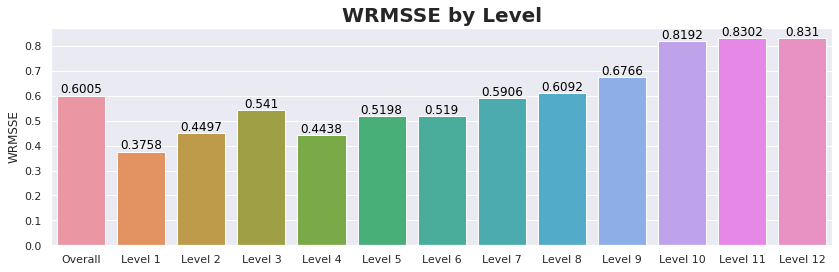

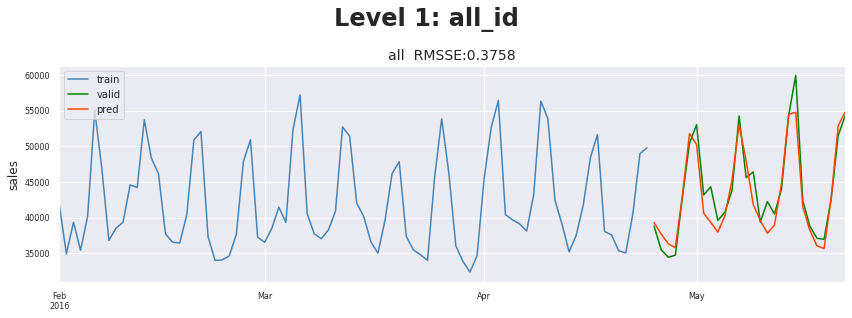

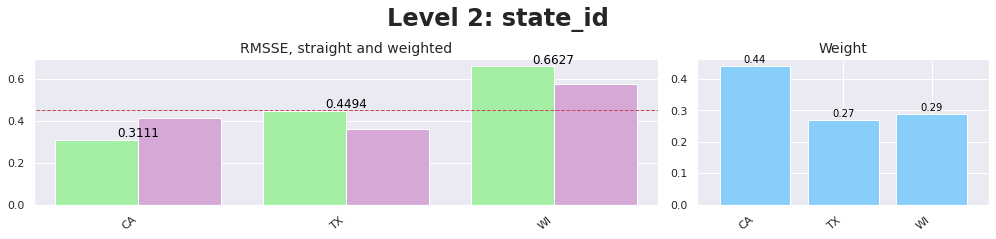

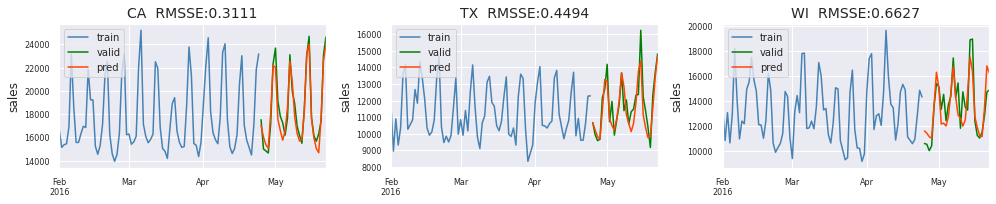

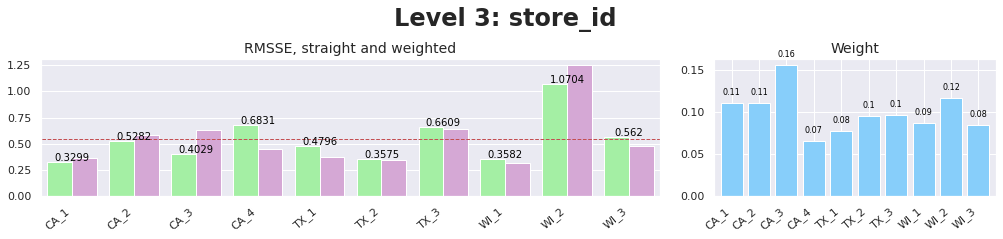

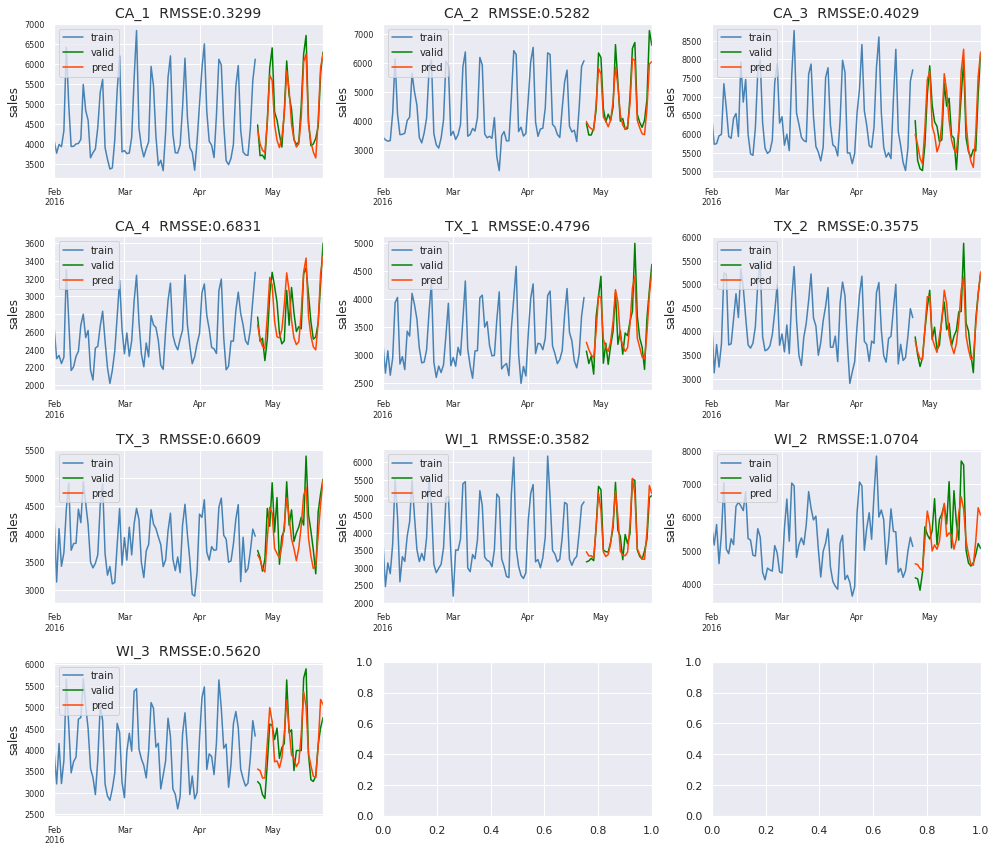

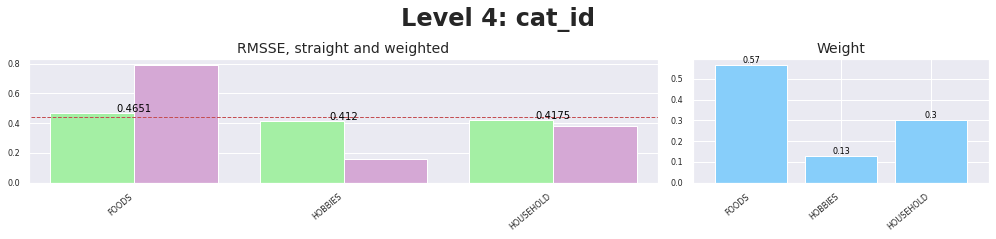

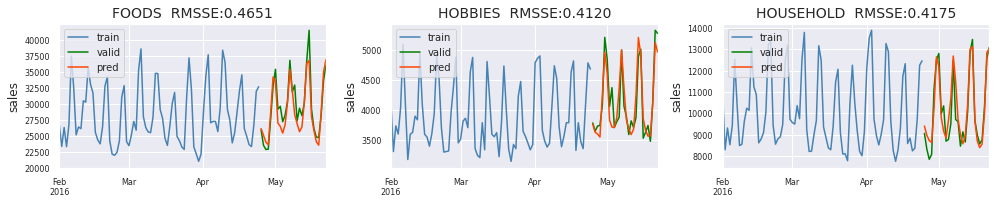

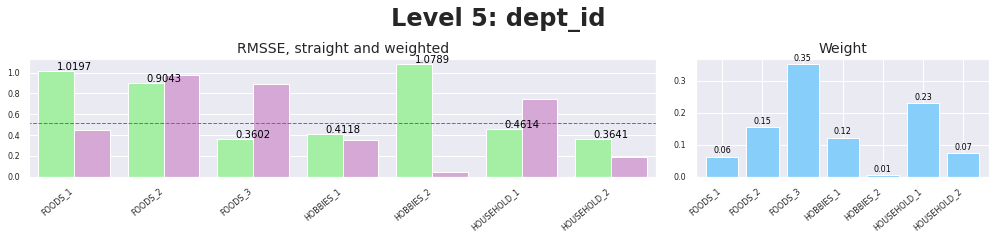

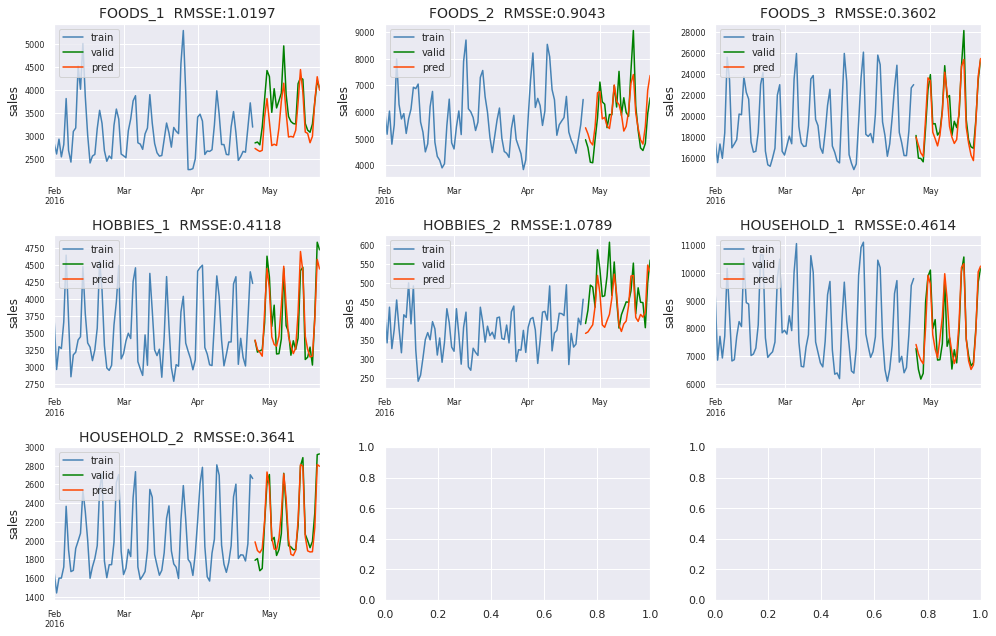

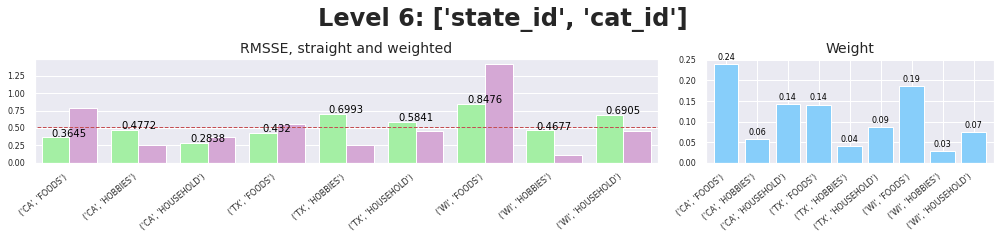

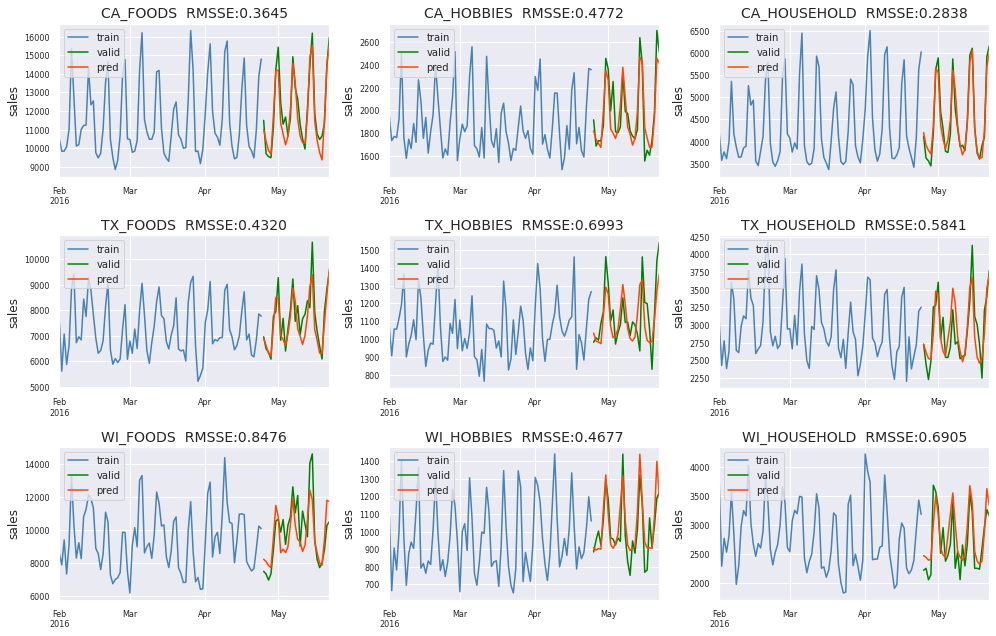

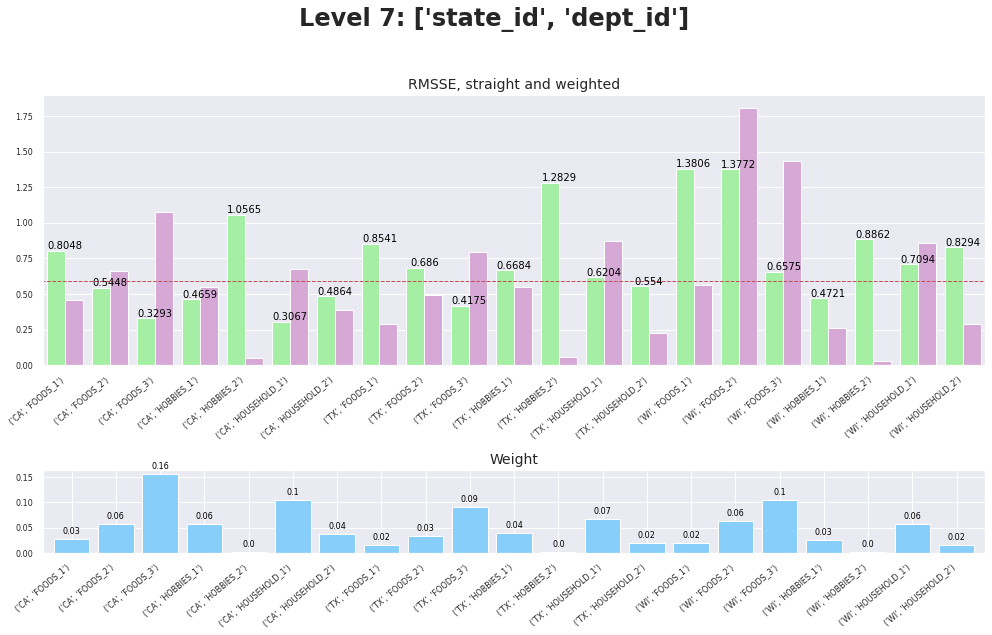

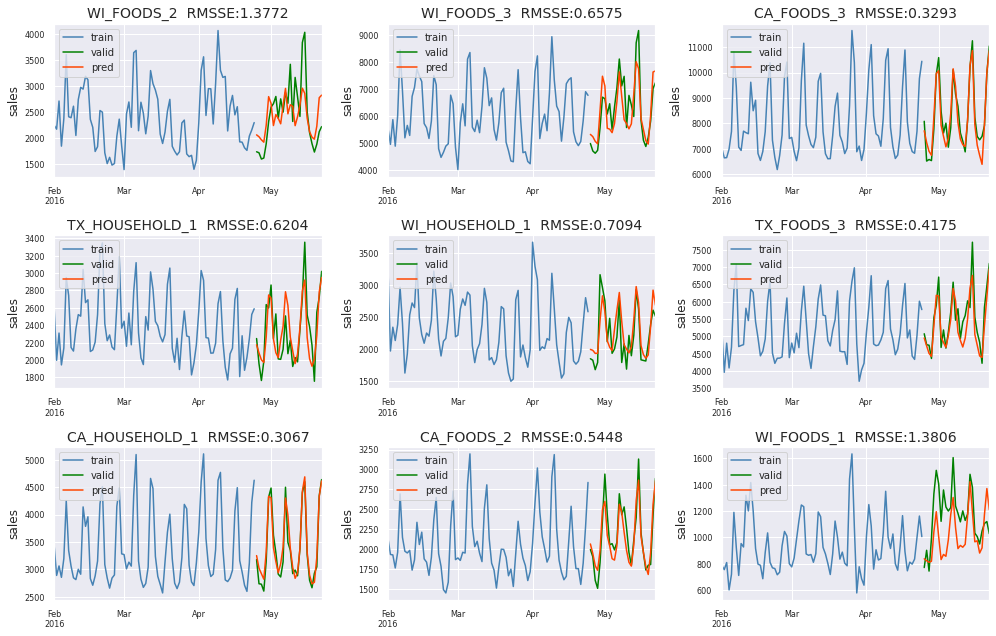

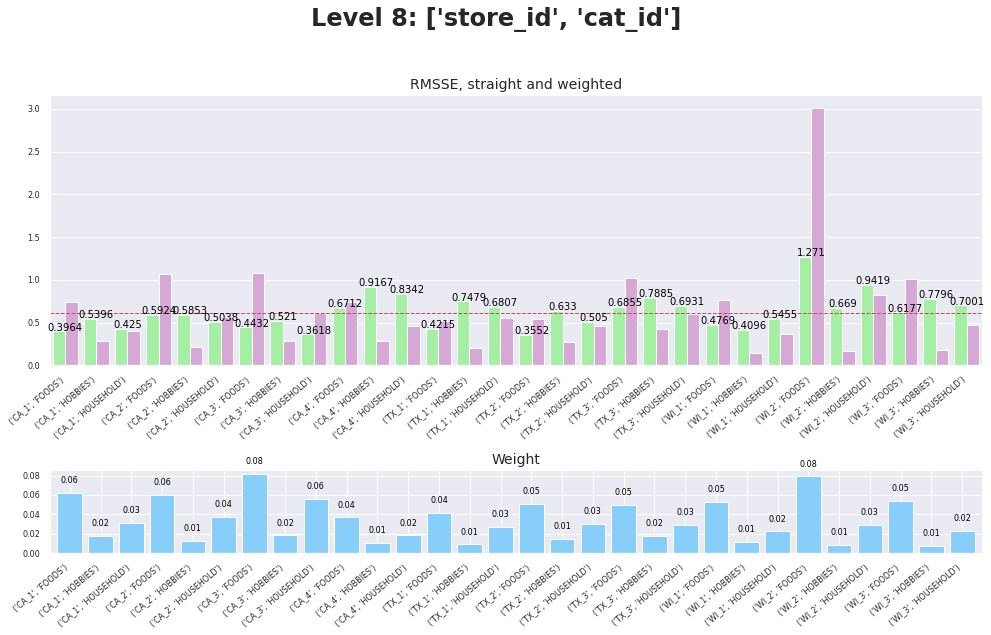

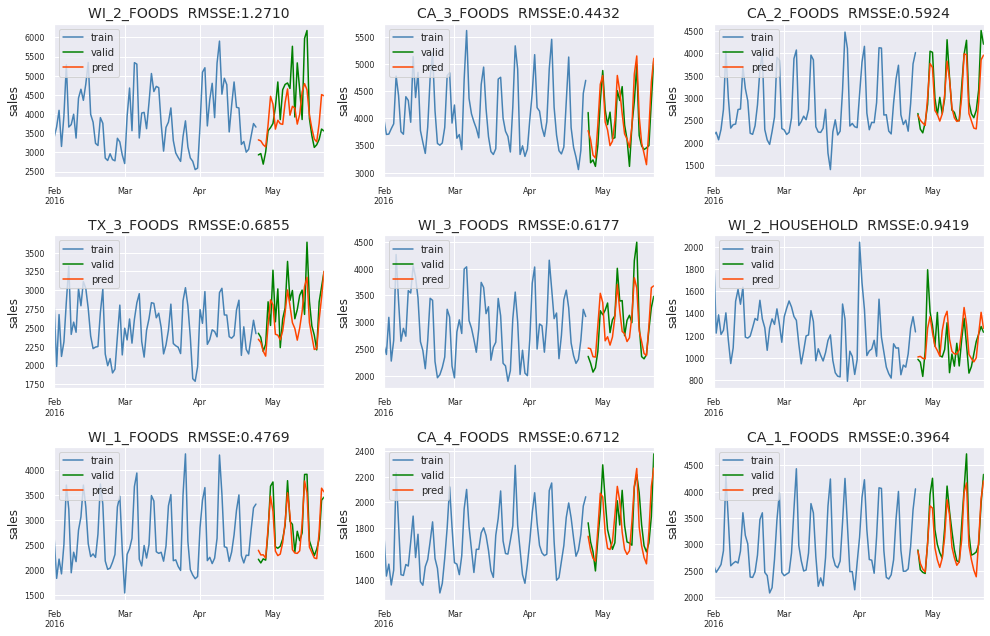

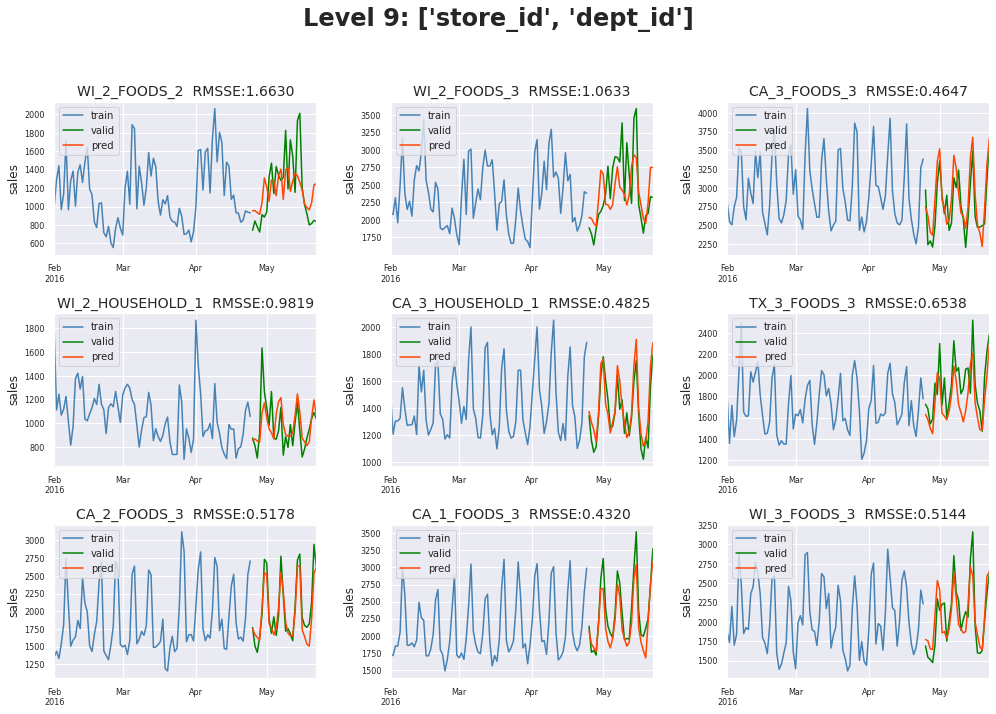

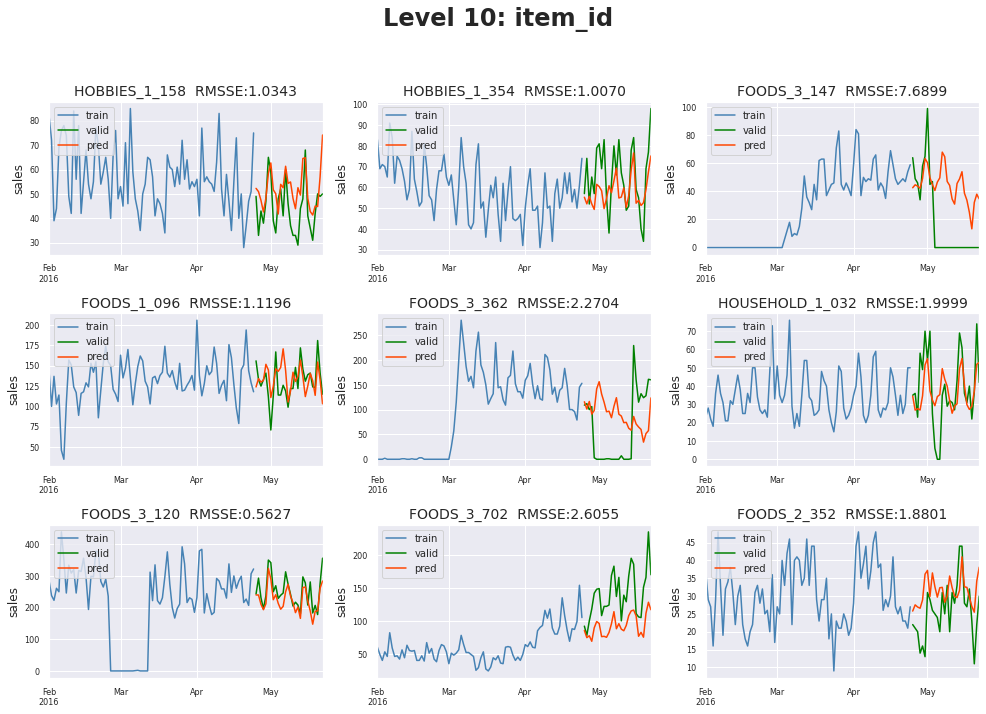

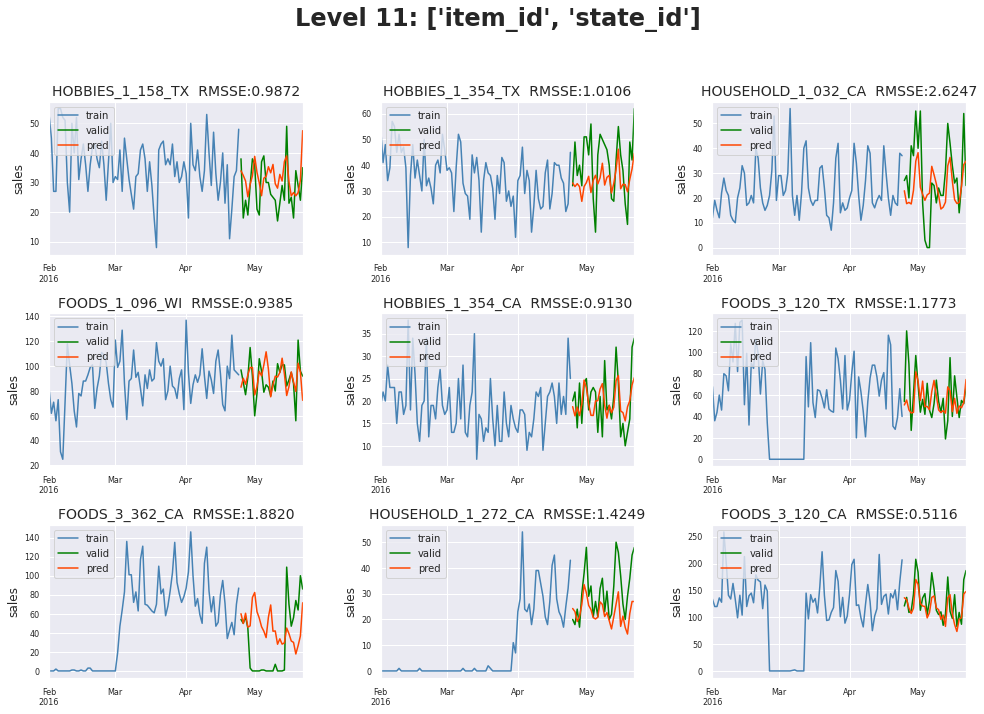

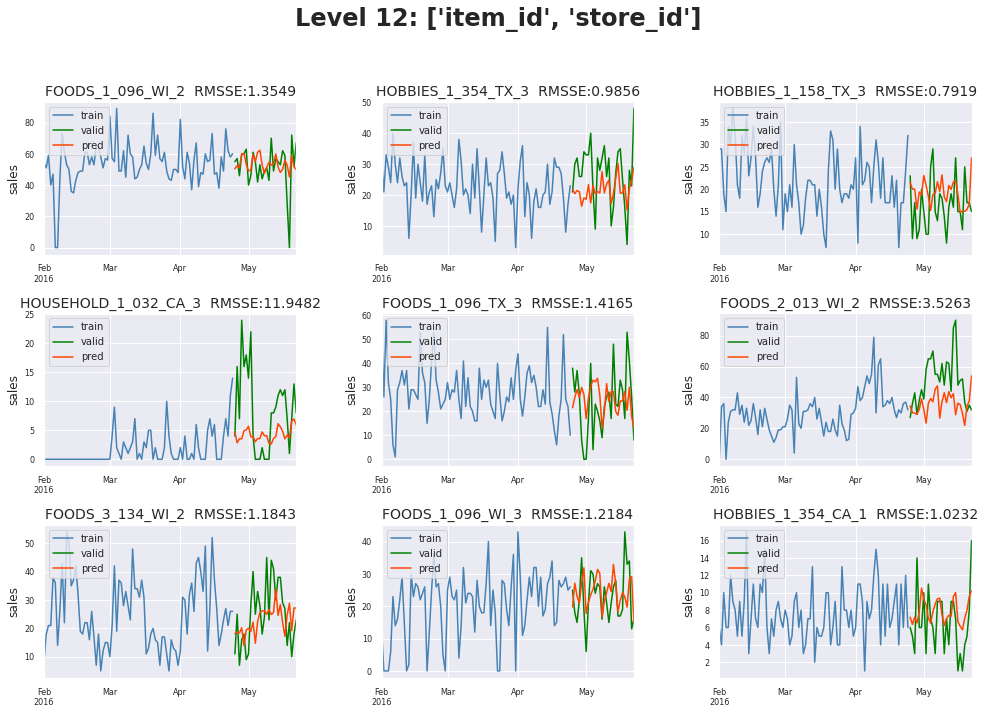

In [15]:
w.create_dashboard(evaluator, groups='all', cal=cal)